### 🛠️ Step 0: 初期設定と環境セットアップ

このステップでは、ノートブックの冒頭に記述する **共通設定ブロック** を構築します。  
学習対象のカラムやデバイス判定、ファイルパス、ロス関数の設計など、全体に関わる変数をここで一元管理することで、ノートブックの保守性・拡張性を高めます。

#### 💡 含まれる要素：

- 予測するカラム（`TARGET_COLS`）の指定  
  ↳ 正規化・ロス設計・モデル出力・評価表示に統一的に利用
- バッチサイズや画像サイズ、エポック数などのハイパーパラメータ
- 入出力ファイルパスの一元管理（CSV・画像・正規化パラメータJSONなど）
- デバイス（CUDA / MPS / CPU）の自動判定（Mac対応）
- `tqdm`、`torchinfo` などの可視化系ユーティリティの準備

#### 🔥 利点：

- **パラメータ追加や構成変更に強い設計**が可能になる
- **正規化・重み付きロスとの整合性を保てる**
- **Mac環境・GPU環境に自動対応**でき、可搬性も高い

In [1]:
# === ライブラリの読み込み ===
import torch
from pathlib import Path
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from PIL import Image
from tqdm import tqdm
from torchinfo import summary
import pandas as pd
import numpy as np
import json
import math
import matplotlib.pyplot as plt
import wandb

# === パラメータ設定 ===
TARGET_COLS = ["dipCount", "hue", "circleCount"]  # 学習対象パラメータ（今後拡張可）

IMAGE_SIZE = 128
BATCH_SIZE = 32
NUM_EPOCHS = 10
LEARNING_RATE = 0.001
PREFIX = "image_"

# === ファイルパス設定 ===
DATA_DIR = Path("../../data/circle-stroke")
CSV_PATH = DATA_DIR / "metadata.csv"
IMG_DIR = DATA_DIR / "images"
NORMALIZATION_PATH = DATA_DIR / "normalization_params.json"

# === デバイス自動判定（MacのMPSも対応）===
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(f"✅ Using device: {device}")

✅ Using device: mps


### 🧮 Step 1: メタデータの読み込みと前処理（正規化）

このステップでは、CSVからメタデータを読み込み、学習対象のパラメータ列（`TARGET_COLS`）を抽出し、  
さらに画像ファイルの存在を確認して有効なデータのみを選別します。  
加えて、各パラメータを **Z-score正規化** し、その平均と標準偏差をJSONに保存します。

#### 💡 含まれる要素：

- `pandas` でCSV読み込み
- `TARGET_COLS` に基づいて学習用ラベルを抽出
- ファイル名・フルパスを生成し、実在する画像ファイルのみにフィルタリング
- 各パラメータを **Z-score（平均0, 標準偏差1）正規化**
- **`normalization_params.json`** に保存して、逆変換や評価時に再利用可能に

#### 🔥 利点：

- 学習の安定性向上と多パラメータのスケール統一
- 逆正規化処理の基盤を構築できる
- 画像の存在チェックによってエラーを未然に防げる

In [2]:
# === メタデータの読み込み ===
df = pd.read_csv(CSV_PATH)

# id列とターゲット列だけを抽出（+ファイル名・パス生成）
df_targets = df[["id"] + TARGET_COLS].copy()
df_targets["filename"] = df_targets["id"].apply(lambda x: f"{PREFIX}{x}.png")
df_targets["filepath"] = df_targets["filename"].apply(lambda x: IMG_DIR / x)

# 実在するファイルのみにフィルタリング
df_targets = df_targets[df_targets["filepath"].apply(lambda x: x.exists())].reset_index(drop=True)

# === 各ラベル列を Z-score 正規化 ===
normalization_params = {}

for col in TARGET_COLS:
    mean = df_targets[col].mean()
    std = df_targets[col].std()
    df_targets[col] = (df_targets[col] - mean) / std
    normalization_params[col] = {"mean": mean, "std": std}

# 正規化パラメータをJSON保存（逆変換に使う）
with open(NORMALIZATION_PATH, "w") as f:
    json.dump(normalization_params, f, indent=2)

# チェック表示
print(f"✅ 使用可能なデータ数: {len(df_targets)}")
print(f"🎯 ターゲット列: {TARGET_COLS}")

✅ 使用可能なデータ数: 999
🎯 ターゲット列: ['dipCount', 'hue', 'circleCount']


### 🧾 Step 2: カスタム Dataset クラスの定義とラベル整形

このステップでは、画像と正規化済みラベルを扱うための **カスタム Dataset クラス** を定義します。  
また、`hue` はモデルに直接渡さず、ここで `cos/sin` に変換し、**周期性のある値を連続的に学習できる形**にします。

#### 💡 含まれる要素：

- `Dataset` クラスで画像とラベルをセットで返す構成
- `hue` を `hue_cos`, `hue_sin` に変換（rad → cos/sin）
- `TARGET_COLS` に基づくラベル組み立て（拡張にも対応）
- 1件目の画像とラベルの確認、画像表示

#### 🔥 利点：

- 周期的パラメータを回帰的に学習できる
- `TARGET_COLS` への準拠で、将来的なパラメータ追加も簡単
- 動作確認でラベル構造を早期にチェックできる

画像サイズ: torch.Size([3, 128, 128])
ラベル（[dipCount, hue_cos, hue_sin, circleCount]）: tensor([-1.1896,  0.9997,  0.0243,  1.0850])


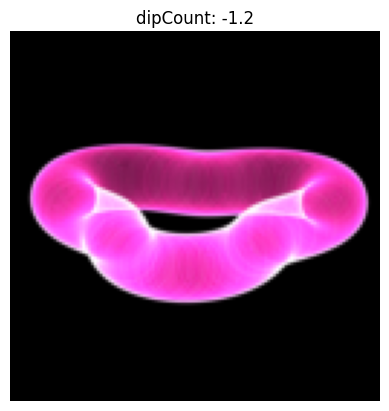

In [3]:
class MultiParamDataset(Dataset):
    def __init__(self, df, img_dir, image_size=128, prefix="image_"):
        self.df = df.reset_index(drop=True)
        self.img_dir = img_dir
        self.prefix = prefix
        self.image_size = image_size
        self.transform = transforms.Compose([
            transforms.Resize((image_size, image_size)),
            transforms.ToTensor()
        ])

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        # 画像読み込み・変換
        img_path = self.img_dir / f"{self.prefix}{row['id']}.png"
        image = Image.open(img_path).convert("RGB")
        image = self.transform(image)

        # ラベルの構築：hueのみcos/sin変換、他はそのまま
        dip = row["dipCount"]
        hue = row["hue"]
        circle = row["circleCount"]

        hue_rad = np.deg2rad(hue)
        hue_cos = np.cos(hue_rad)
        hue_sin = np.sin(hue_rad)

        label = torch.tensor([dip, hue_cos, hue_sin, circle], dtype=torch.float32)

        return image, label

# === 動作確認 ===
sample_dataset = MultiParamDataset(df_targets, IMG_DIR, image_size=IMAGE_SIZE, prefix=PREFIX)
sample_img, sample_label = sample_dataset[0]

print("画像サイズ:", sample_img.shape)
print("ラベル（[dipCount, hue_cos, hue_sin, circleCount]）:", sample_label)

# 可視化
plt.imshow(sample_img.permute(1, 2, 0))
plt.title(f"dipCount: {sample_label[0]:.1f}")
plt.axis("off")
plt.show()

### 🧪 Step 3: 訓練・検証データの分割と DataLoader の作成

このステップでは、事前処理済みの `df_targets` を **訓練・検証に分割**し、  
PyTorchの `DataLoader` を使って、バッチ処理ができる形式に変換します。  
また、分割後のデータ構造を確認して、ラベルが正しく処理されているかを検証します。

#### 💡 含まれる要素：

- `train_test_split` によるデータ分割（再現性確保のため `random_state` 指定）
- `MultiParamDataset` を使った PyTorch データセット化
- `DataLoader` によるミニバッチ化
- バッチ構造やラベル内容の確認（デバッグ）

#### 🔥 利点：

- データの偏りやラベル不整合を早期に発見できる
- `TARGET_COLS` の拡張にも自動的に対応
- ミニバッチでの高速学習に向けた準備が整う

In [4]:
from sklearn.model_selection import train_test_split

# 訓練/検証分割（20%を検証に）
df_train, df_val = train_test_split(df_targets, test_size=0.2, random_state=42)

# Dataset のインスタンスを作成
train_dataset = MultiParamDataset(df_train, IMG_DIR, image_size=IMAGE_SIZE, prefix=PREFIX)
val_dataset = MultiParamDataset(df_val, IMG_DIR, image_size=IMAGE_SIZE, prefix=PREFIX)

# DataLoader の作成
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"✅ train: {len(train_dataset)} samples | val: {len(val_dataset)} samples")

# === バッチ構造確認 ===
images, labels = next(iter(train_loader))
print("🔍 バッチ画像 shape:", images.shape)   # (B, 3, H, W)
print("🔍 バッチラベル shape:", labels.shape) # (B, 4) → [dipCount, hue_cos, hue_sin, circleCount]
print("🎯 ラベルの一部:")
for i, name in enumerate(["dipCount", "hue_cos", "hue_sin", "circleCount"]):
    print(f"  {name}: {labels[:4, i].tolist()}")

✅ train: 799 samples | val: 200 samples
🔍 バッチ画像 shape: torch.Size([32, 3, 128, 128])
🔍 バッチラベル shape: torch.Size([32, 4])
🎯 ラベルの一部:
  dipCount: [0.283019483089447, -0.8214198350906372, -0.45327338576316833, -0.08512695133686066]
  hue_cos: [0.9997950792312622, 0.999790608882904, 0.9999884366989136, 0.9999808669090271]
  hue_sin: [-0.020242134109139442, -0.020464453846216202, -0.004814777057617903, 0.006183688063174486]
  circleCount: [0.09841818362474442, 0.9002032279968262, -0.9264723062515259, 1.0187280178070068]


### 🧠 Step 4: CNNモデルの定義と初期化・構造確認

このステップでは、マルチパラメータ予測に対応した **CNNベースの回帰モデル** を構築します。  
出力ユニット数は `TARGET_COLS` に応じて動的に決定されるため、パラメータの追加・削除にも柔軟に対応できます。

#### 💡 含まれる要素：

- 畳み込み層＋全結合層による構造的な画像特徴抽出
- 出力次元は `TARGET_COLS` の長さに自動対応
- `torchinfo.summary()` による構造とパラメータ数の可視化

#### 🔥 利点：

- 複数パラメータを一括で回帰可能
- モデルの構造が拡張・変更しやすい
- GPU／MPSを活用した高速学習の準備が整う

In [5]:
import torch.nn as nn
import torch.nn.functional as F

class MultiParamCNN(nn.Module):
    def __init__(self, image_size=128, output_dim=len(TARGET_COLS) + 1):  # +1 for hue_cos/sin展開分
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)

        flatten_size = 32 * (image_size // 4) * (image_size // 4)
        self.fc1 = nn.Linear(flatten_size, 64)
        self.fc2 = nn.Linear(64, output_dim)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# === モデルインスタンス化 & 構造確認 ===
model = MultiParamCNN(image_size=IMAGE_SIZE, output_dim=4).to(device)
summary(model, input_size=(BATCH_SIZE, 3, IMAGE_SIZE, IMAGE_SIZE))

Layer (type:depth-idx)                   Output Shape              Param #
MultiParamCNN                            [32, 4]                   --
├─Conv2d: 1-1                            [32, 16, 128, 128]        448
├─MaxPool2d: 1-2                         [32, 16, 64, 64]          --
├─Conv2d: 1-3                            [32, 32, 64, 64]          4,640
├─MaxPool2d: 1-4                         [32, 32, 32, 32]          --
├─Linear: 1-5                            [32, 64]                  2,097,216
├─Linear: 1-6                            [32, 4]                   260
Total params: 2,102,564
Trainable params: 2,102,564
Non-trainable params: 0
Total mult-adds (M): 910.17
Input size (MB): 6.29
Forward/backward pass size (MB): 100.68
Params size (MB): 8.41
Estimated Total Size (MB): 115.38

### 🏋️‍♀️ Step 5: 学習ループの構築と wandb ログ管理（＋重み付きMSE）

このステップでは、モデルの学習と検証を行うループを定義し、  
`wandb` を使ってログを記録します。また、各出力に対して重みを持たせた **Weighted MSE Loss** を導入し、  
スケール差のあるパラメータ同士をバランスよく学習させます。

#### 💡 含まれる要素：

- `WeightedMSELoss` の定義と導入
- `wandb` によるハイパーパラメータと損失の記録
- 各エポックごとの train / val 損失の蓄積と出力

#### 🔥 利点：

- パラメータ間の学習バランスを調整可能
- GPU / MPS 上での安定した学習
- `wandb` による履歴管理で再現性・可視化が強化される

In [6]:
# === カスタム Weighted MSELoss 定義 ===
class WeightedMSELoss(nn.Module):
    def __init__(self, weights):
        super().__init__()
        self.weights = torch.tensor(weights).float()

    def forward(self, pred, target):
        return ((self.weights.to(pred.device) * (pred - target) ** 2).mean())

# === wandb 初期化（前回セッションの衝突を避けるため finish()）===
wandb.finish()
wandb.init(
    project="parametric-visual-learning",
    name="image2params_v2_weighted",
    config={
        "epochs": NUM_EPOCHS,
        "batch_size": BATCH_SIZE,
        "learning_rate": LEARNING_RATE,
        "target_cols": TARGET_COLS,
        "image_size": IMAGE_SIZE,
    }
)

# === モデル・損失・最適化設定 ===
model = MultiParamCNN(image_size=IMAGE_SIZE, output_dim=4).to(device)

loss_weights = [1.0, 0.5, 0.5, 0.8]  # [dipCount, hue_cos, hue_sin, circleCount] の重み
criterion = WeightedMSELoss(loss_weights)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

train_losses = []
val_losses = []

# === 学習ループ ===
for epoch in range(NUM_EPOCHS):
    model.train()
    total_loss = 0.0

    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS}")
    for images, labels in loop:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * images.size(0)
        loop.set_postfix(loss=loss.item())

    avg_train_loss = total_loss / len(train_loader.dataset)
    train_losses.append(avg_train_loss)

    # === 検証ループ ===
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)

    avg_val_loss = val_loss / len(val_loader.dataset)
    val_losses.append(avg_val_loss)

    # === wandb ログ ===
    wandb.log({
        "epoch": epoch + 1,
        "train_loss": avg_train_loss,
        "val_loss": avg_val_loss
    })

    print(f"[{epoch+1}] 🟢 Train Loss: {avg_train_loss:.4f} | 🔵 Val Loss: {avg_val_loss:.4f}")

wandb.finish()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: kimurakoya (ritsumeikan-math). Use `wandb login --relogin` to force relogin


Epoch 1/10: 100%|██████████| 25/25 [00:36<00:00,  1.44s/it, loss=0.328]


[1] 🟢 Train Loss: 0.3885 | 🔵 Val Loss: 0.2914


Epoch 2/10: 100%|██████████| 25/25 [00:22<00:00,  1.12it/s, loss=0.0889]


[2] 🟢 Train Loss: 0.1604 | 🔵 Val Loss: 0.1107


Epoch 3/10: 100%|██████████| 25/25 [00:22<00:00,  1.09it/s, loss=0.0485]


[3] 🟢 Train Loss: 0.0553 | 🔵 Val Loss: 0.0524


Epoch 4/10: 100%|██████████| 25/25 [00:21<00:00,  1.19it/s, loss=0.0152]


[4] 🟢 Train Loss: 0.0307 | 🔵 Val Loss: 0.0354


Epoch 5/10: 100%|██████████| 25/25 [00:20<00:00,  1.23it/s, loss=0.0152]


[5] 🟢 Train Loss: 0.0206 | 🔵 Val Loss: 0.0260


Epoch 6/10: 100%|██████████| 25/25 [00:18<00:00,  1.33it/s, loss=0.0126] 


[6] 🟢 Train Loss: 0.0107 | 🔵 Val Loss: 0.0150


Epoch 7/10: 100%|██████████| 25/25 [00:19<00:00,  1.29it/s, loss=0.00442]


[7] 🟢 Train Loss: 0.0074 | 🔵 Val Loss: 0.0163


Epoch 8/10: 100%|██████████| 25/25 [00:20<00:00,  1.20it/s, loss=0.00867]


[8] 🟢 Train Loss: 0.0068 | 🔵 Val Loss: 0.0135


Epoch 9/10: 100%|██████████| 25/25 [00:18<00:00,  1.38it/s, loss=0.00631]


[9] 🟢 Train Loss: 0.0091 | 🔵 Val Loss: 0.0286


Epoch 10/10: 100%|██████████| 25/25 [00:18<00:00,  1.37it/s, loss=0.00817]


[10] 🟢 Train Loss: 0.0112 | 🔵 Val Loss: 0.0162


epoch,▁▂▃▃▄▅▆▆▇█
train_loss,█▄▂▁▁▁▁▁▁▁
val_loss,█▃▂▂▁▁▁▁▁▁
epoch,10
train_loss,0.01124
val_loss,0.01624


### 🔍 Step 6: 推論と逆正規化による予測結果の可視化

このステップでは、検証用データに対してモデルから予測を行い、  
出力値を **逆正規化**して人が解釈可能なスケールに戻します。  
`hue_cos/sin` の出力は角度に変換し、予測と真値を並べて画像ごとに可視化します。

#### 💡 含まれる要素：

- モデルの `.eval()` による推論モード設定
- `normalization_params.json` を使った逆正規化関数
- `hue_cos/sin` を角度に再変換（周期誤差を扱いやすく）
- matplotlibによる画像ごとの予測 vs 真値表示

#### 🔥 利点：

- モデルの精度を視覚的に把握できる
- 正規化された学習でも、**意味ある出力解釈**が可能
- 周期性を持つパラメータ（hue）に特化した誤差評価が可能

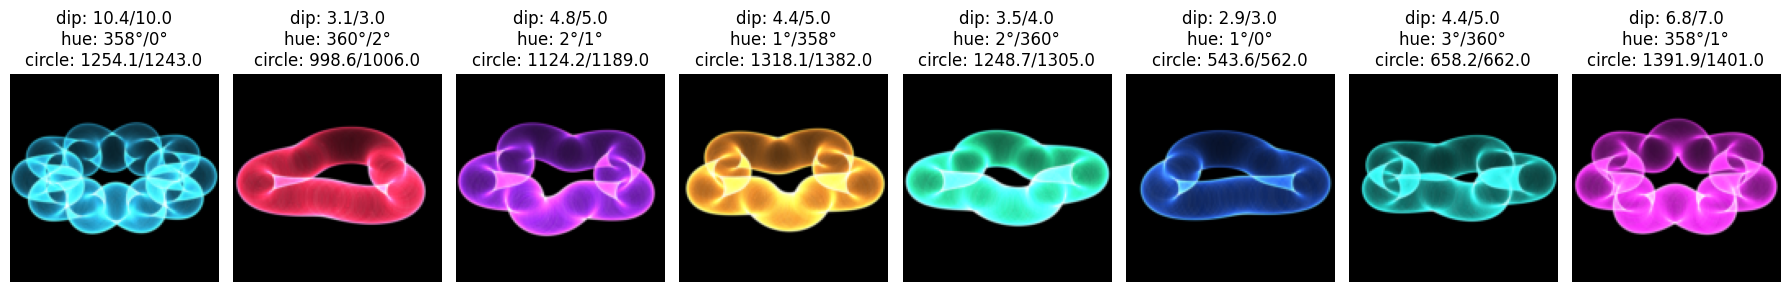

In [7]:
# === 正規化パラメータの読み込み ===
with open(NORMALIZATION_PATH) as f:
    norm_params = json.load(f)

# === 逆正規化関数 ===
def denormalize(value, col_name):
    mean = norm_params[col_name]['mean']
    std = norm_params[col_name]['std']
    return value * std + mean

# === 推論と可視化 ===
model.eval()

num_samples = 8
plt.figure(figsize=(18, 4))

for i in range(num_samples):
    image, label = val_dataset[i]
    with torch.no_grad():
        pred = model(image.unsqueeze(0).to(device)).squeeze().cpu()

    # ラベル値と予測値（逆正規化前提）
    dip_gt = denormalize(label[0].item(), "dipCount")
    hue_cos_gt = label[1].item()
    hue_sin_gt = label[2].item()
    circle_gt = denormalize(label[3].item(), "circleCount")

    dip_pred = denormalize(pred[0].item(), "dipCount")
    hue_cos_pred = pred[1].item()
    hue_sin_pred = pred[2].item()
    circle_pred = denormalize(pred[3].item(), "circleCount")

    # hue角度へ変換（0〜360°）
    hue_gt = np.rad2deg(np.arctan2(hue_sin_gt, hue_cos_gt)) % 360
    hue_pred = np.rad2deg(np.arctan2(hue_sin_pred, hue_cos_pred)) % 360

    # 可視化
    plt.subplot(1, num_samples, i + 1)
    plt.imshow(image.permute(1, 2, 0))
    plt.title(
        f"dip: {dip_pred:.1f}/{dip_gt:.1f}\n"
        f"hue: {hue_pred:.0f}°/{hue_gt:.0f}°\n"
        f"circle: {circle_pred:.1f}/{circle_gt:.1f}"
    )
    plt.axis("off")

plt.tight_layout()
plt.show()

### 📉 Step 7: 学習過程の損失カーブ可視化

このステップでは、学習過程で記録した `train_loss` / `val_loss` の推移をグラフとして可視化します。  
今回は **正規化＋重み付きMSELoss** を使っているため、損失の意味は「各出力に重みをかけた正規化MSEの合計」となります。

#### 💡 含まれる要素：

- matplotlib による損失推移の描画
- epoch に対する `train_loss` / `val_loss` の可視化

#### 🔥 利点：

- 学習の進行具合を一目で確認できる
- 過学習や未学習の兆候を視覚的に把握できる
- wandbのログと併せて、再現性の高い実験管理が可能になる

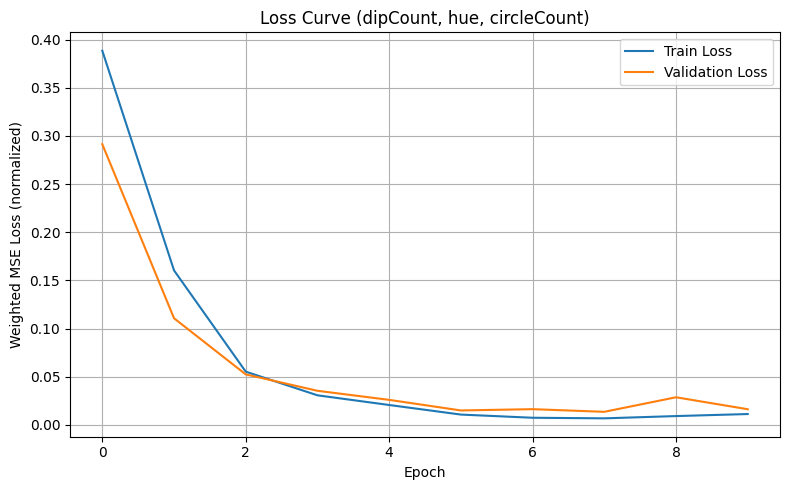

In [8]:
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Weighted MSE Loss (normalized)")
plt.title("Loss Curve (dipCount, hue, circleCount)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()